In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('authority-modularity.csv')
df=df.drop(['Label','timeset','Hub'],axis=1)

indexNames = df[ (df.modularity_class != 11) & (df.modularity_class != 9) & (df.modularity_class != 4) ].index
df.drop(indexNames , inplace=True)

df.modularity_class.value_counts()

11    455
9     336
4     276
Name: modularity_class, dtype: int64

In [2]:
first10_cl11=df[df.modularity_class == 11].sort_values('Authority', ascending=False).head(10)
first10_cl4=df[df.modularity_class == 4].sort_values('Authority', ascending=False).head(10)
first10_cl9=df[df.modularity_class == 9].sort_values('Authority', ascending=False).head(10)

utenti_cl11=first10_cl11.Id.tolist()
utenti_cl4=first10_cl4.Id.tolist()
utenti_cl9=first10_cl9.Id.tolist()

utenti_final= utenti_cl11+utenti_cl4+utenti_cl9

In [3]:
import tweepy

ACCESS_TOKEN = '1089903781880434688-SDhXR2aBBr54lZQ8QnPaE4mUR6TrOd'
ACCESS_SECRET = 'D6wHvFEmbL3W0FSP70jxBRpIYs53UGxuQlQ5yHf578ZDt'
CONSUMER_KEY = 'kGR5GYd09tSmQCJeyprOKlKeV'
CONSUMER_SECRET = 'MNeyyl0SkUOGgkIs8kDdZktPi2HCxC7mTv6re4GywsiarZDR3c'


auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET) 
  
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET) 

api = tweepy.API(auth)


from datetime import timedelta, datetime

for idx, utente in enumerate(utenti_final):
    try:
        last_tweet = api.user_timeline(user_id=utente, count=1) 
        created_at = last_tweet[0].created_at
    
        if (created_at > datetime.now() - timedelta(days=90)):
            print('{}: this user is still active: {}\tlast post: {}'.format(idx,utente,created_at))
        else:
            utenti_final.remove(utente)
            print('inactive user {} droppato'.format(utente))
                
    except Exception as err:
        print(err)
        utenti_final.remove(utente)
        print('inactive user {} droppato'.format(utente))
        continue

Not authorized.
inactive user 123926189 droppato
1: this user is still active: 52456063	last post: 2019-08-30 09:54:02
2: this user is still active: 18119568	last post: 2019-08-30 07:36:45
3: this user is still active: 14872161	last post: 2019-08-30 03:34:51
4: this user is still active: 10236782	last post: 2019-08-30 10:59:52
inactive user 45762728 droppato
6: this user is still active: 171656520	last post: 2019-08-30 04:47:53
7: this user is still active: 21765964	last post: 2019-08-30 04:50:07
Not authorized.
inactive user 15773072 droppato
inactive user 42919671 droppato
10: this user is still active: 54292369	last post: 2019-08-27 23:11:08
11: this user is still active: 18084838	last post: 2019-08-30 04:58:11
12: this user is still active: 41823835	last post: 2019-08-30 06:33:41
13: this user is still active: 94853291	last post: 2019-08-30 00:38:03
14: this user is still active: 14983173	last post: 2019-08-30 05:22:54
15: this user is still active: 15279465	last post: 2019-08-30 0

In [4]:
from pymongo import MongoClient

client = MongoClient('localhost', 27017)
db = client['twitter']

data = pd.DataFrame(columns=['Tweets'])

for user in utenti_final:
    
    print('colleziono tweet utente numero:', user)

    pipeline=[{ "$project": {  "id_user" : 1, "originalTweet" : 1, "hashtag" : 1, "mention" : 1}}, { "$match": {  "id_user" : user} }]

    cursor_list = list(db['tweets'].aggregate(pipeline))

    tweets = pd.DataFrame(cursor_list)
    data=data.append(tweets, sort=True)

dfAll = pd.DataFrame(data.originalTweet)
dfAll.head(5)

colleziono tweet utente numero: 113283096
colleziono tweet utente numero: 52456063
colleziono tweet utente numero: 18119568
colleziono tweet utente numero: 14872161
colleziono tweet utente numero: 10236782
colleziono tweet utente numero: 175339579
colleziono tweet utente numero: 171656520
colleziono tweet utente numero: 21765964
colleziono tweet utente numero: 16252960
colleziono tweet utente numero: 56669858
colleziono tweet utente numero: 54292369
colleziono tweet utente numero: 18084838
colleziono tweet utente numero: 41823835
colleziono tweet utente numero: 94853291
colleziono tweet utente numero: 14983173
colleziono tweet utente numero: 15279465
colleziono tweet utente numero: 88071033
colleziono tweet utente numero: 113410319
colleziono tweet utente numero: 17383566
colleziono tweet utente numero: 37725640
colleziono tweet utente numero: 29268171
colleziono tweet utente numero: 17268481
colleziono tweet utente numero: 212402248
colleziono tweet utente numero: 15700177


,originalTweet
0,RT @7thclouds: #小池百合子 #大臣 就任直後 #イージス艦情報横流した側 #...
1,#小池百合子 #大臣 就任直後 #イージス艦情報横流した側 #幸福の科学 #勝共連合 反日「...
2,RT @7thclouds: #小池百合子 #大臣 就任直後 #イージス艦情報横流し 側 #...
3,#小池百合子 #大臣 就任直後 #イージス艦情報横流し 側 #幸福の科学 所謂統一教会系ナチ...
4,RT @7thclouds: @sputnik_jp<#いうこととやること正反対 #小池百合...


In [5]:
trumpTweet = dfAll[dfAll.originalTweet.str.contains("(?:^|\W)#Trump(?:$|\W)|\
                                                (?:^|\W)#DonaldTrump(?:$|\W)|\
                                                (?:^|\W)#trump(?:$|\W)|\
                                                (?:^|\W)@realDonaldTrump(?:$|\W)\
                                                (?:^|\W)#donaldtrump(?:$|\W)\
                                                (?:^|\W)Trump(?:$|\W)|\
                                                (?:^|\W)DonaldTrump(?:$|\W)|\
                                                (?:^|\W)trump(?:$|\W)|\
                                                (?:^|\W)realDonaldTrump(?:$|\W)\
                                                (?:^|\W)donaldtrump(?:$|\W)")]

![title](process.png)

In [6]:
from nltk.corpus import stopwords
from nltk import word_tokenize
import re
import string

def clean_tweets(tweet):
 
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(tweet)
#after tweepy preprocessing the colon symbol left remain after      #removing mentions
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
#replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
#remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)
#filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []
#looping through conditions
    for w in word_tokens:
#check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
    return ' '.join(filtered_tweet)
    #print(word_tokens)
    #print(filtered_sentence)return tweet
    
#HappyEmoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

#Emoji patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

emoticons = emoticons_happy.union(emoticons_sad)

In [7]:
documents = [clean_tweets(s) for s in trumpTweet.originalTweet]

In [8]:
documents

['RT 7thclouds DNC Nazis Whitesuoremacy Vikinggang antilaw antieconomy Trump Bernie greens anarchism USA https //t…',
 'RT_America RT_com DNC Nazis Whitesuoremacy Vikinggang antilaw antieconomy Trump Bernie gp greens anarchism USA',
 'DNC Nazis Whitesuoremacy Vikinggang antilaw antieconomy Trump Bernie greens anarchism USA https //t.co/i7kTBXDtrK',
 'RT 7thclouds Trump UnificationChurch Greens Nazis liars taking anything anyone vikinhgang country https //…',
 'Trump UnificationChurch Greens Nazis liars taking anything anyone vikinhgang country https //t.co/pY6nwqvYZ0',
 'Bush Texas show rejection Trump= Greens hate thermal electric generation modernization https //t.co/pV8i1Qze1W',
 "RT 7thclouds SputnikInt US `` accident '' kills legitimacy Syria exactly Nazis Burnie Trump want Nazis 's ultimate target U…",
 "SputnikInt US `` accident '' kills legitimacy Syria exactly Nazis Burnie Trump want Nazis 's ultimate target US",
 "RT 7thclouds US `` accident '' kills itslegitimacy Syria exact

In [9]:
from sentistrength import PySentiStr

senti = PySentiStr()

senti.setSentiStrengthPath('/media/alessandro/storage/Tesi/locale/sentiStrength/SentiStrength.jar')
senti.setSentiStrengthLanguageFolderPath('/media/alessandro/storage/Tesi/locale/sentiStrength/SentiStrength_Data/')


result = senti.getSentiment(documents, score='binary')

print(result)

[(1, -1), (1, -1), (1, -1), (1, -3), (1, -3), (1, -4), (1, -2), (1, -2), (1, -2), (1, -2), (1, -3), (1, -3), (1, -3), (1, -3), (1, -4), (1, -4), (1, -2), (1, -2), (1, -2), (1, -2), (1, -2), (1, -2), (1, -2), (1, -4), (1, -4), (1, -4), (1, -4), (1, -4), (3, -4), (1, -4), (1, -4), (3, -4), (3, -4), (3, -4), (3, -4), (3, -4), (3, -4), (3, -4), (3, -4), (3, -4), (3, -4), (3, -4), (3, -4), (3, -4), (3, -4), (3, -4), (3, -4), (3, -4), (1, -1), (1, -1), (1, -1), (1, -1), (1, -4), (1, -1), (1, -4), (1, -4), (1, -2), (1, -2), (1, -1), (1, -4), (1, -4), (1, -1), (1, -1), (1, -1), (1, -2), (1, -2), (1, -2), (1, -4), (1, -4), (1, -4), (1, -4), (1, -1), (1, -1), (3, -4), (1, -1), (1, -1), (1, -1), (1, -1), (1, -3), (1, -2), (1, -2), (1, -2), (1, -3), (1, -3), (2, -1), (2, -1), (2, -1), (2, -2), (2, -2), (2, -1), (1, -4), (1, -2), (1, -4), (1, -2), (1, -2), (1, -2), (1, -4), (1, -4), (1, -4), (1, -4), (1, -4), (1, -4), (1, -4), (1, -4), (2, -2), (2, -2), (2, -2), (2, -2), (1, -2), (1, -2), (1, -2), 

In [10]:
pd.set_option('display.max_colwidth', -1)

trumpTweet['sentiment']=result

/media/alessandro/storage/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
trumpTweet

,originalTweet,sentiment
1393,RT @7thclouds: #DNC #Nazis #Whitesuoremacy #Vikinggang of antilaw antieconomy by #Trump & #Bernie #greens #anarchism against #USA https://t…,"(1, -1)"
1427,@RT_America @RT_com<#DNC #Nazis #Whitesuoremacy #Vikinggang of antilaw antieconomy by #Trump & #Bernie #gp #greens #anarchism against #USA,"(1, -1)"
1428,#DNC #Nazis #Whitesuoremacy #Vikinggang of antilaw antieconomy by #Trump & #Bernie #greens #anarchism against #USA https://t.co/i7kTBXDtrK,"(1, -1)"
2881,"RT @7thclouds: #Trump #UnificationChurch #Greens #Nazis liars taking anything from anyone #vikinhgang,which is same in any country https://…","(1, -3)"
2945,"#Trump #UnificationChurch #Greens #Nazis liars taking anything from anyone #vikinhgang,which is same in any country https://t.co/pY6nwqvYZ0","(1, -3)"
2951,#Bush = #Texas show its rejection to #Trump=#Greens hate against any thermal electric generation #modernization https://t.co/pV8i1Qze1W,"(1, -4)"
5263,"RT @7thclouds: @SputnikInt<#US ""accident"" kills its legitimacy in #Syria exactly #Nazis #Burnie #Trump want Nazis's ultimate target their U…","(1, -2)"
5265,"@SputnikInt<#US ""accident"" kills its legitimacy in #Syria exactly #Nazis #Burnie #Trump want Nazis's ultimate target their US to do","(1, -2)"
5266,"RT @7thclouds: #US ""accident"" kills itslegitimacy in #Syria exactly #Nazis #Burnie #Trump want Nazis ultimate target their US to do https:/…","(1, -2)"
5267,"#US ""accident"" kills itslegitimacy in #Syria exactly #Nazis #Burnie #Trump want Nazis ultimate target their US to do https://t.co/fWqBWCf8LZ","(1, -2)"


In [12]:
counts = {}
counts['neutral']=0
counts['positive']=0
counts['negative']=0


for el in result:
    if (el[0]+el[1]==0) :
        counts['neutral']+=1
    elif (el[0]+el[1]<0):
        counts['negative']+=1
    else: counts['positive']+=1

counts

{'neutral': 486, 'positive': 109, 'negative': 410}

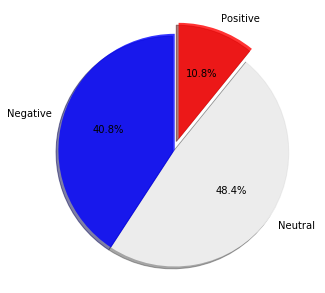

In [14]:
import matplotlib
import matplotlib.pyplot as plt

sizes = [counts['negative'], counts['neutral'], counts['positive']]
explode = (0, 0, 0.1)
labels = 'Negative', 'Neutral', 'Positive'
plt.figure(figsize=(5,5))
plt.pie(sizes, explode=explode, colors="bwr", labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, wedgeprops={'alpha':0.8})
plt.axis('equal') 
plt.show()